In [1]:
# variable for whether running on colab or not
running_on_colab = True

In [2]:
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    
    import subprocess
    subprocess.run("pip install pyrsgis", shell=True)
    subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

Mounted at /content/drive


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataImageUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# constants for program

input_bands = [i+1 for i in range(0,7)]
nBands = len(input_bands)
ndvi_band = 9
labels_band = 8

kSize = 7
stride = 1

downsampleMajority = False

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)
print('Kernel size: ', kSize)
print('Stride: ', stride)
print('Downsample majority class: ', downsampleMajority)



diu.setGlobalVariables(input_bands, nBands)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/Images/"
else: image_base_path = "../SatelliteImages/"
    
saveTrainingData = False
loadTrainingData = False
data_model_base_path = "/content/drive/MyDrive/MangroveClassification/Data_and_Models/"
# data_model_base_path = "../DataAndModels/"
    
saveModel = True
loadModel = False

savedModelName = data_model_base_path + 'CNN_Model_F1_0.928_AUC_0.994.h5'

print('Loading model: ', loadModel)
if loadModel:
    print('Loading model name: ', savedModelName)
else:
    print('Saving model: ', saveModel)
    print('Loading training data: ', loadTrainingData)
    print('Saving training data: ', saveTrainingData)


Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7
Kernel size:  7
Stride:  1
Downsample majority class:  False
Loading model:  False
Saving model:  True
Loading training data:  False
Saving training data:  False


In [5]:
# generate training data from chosen images or load it in

if (loadTrainingData or saveTrainingData) and not running_on_colab:
    raise Exception("Trying to load or save training data, but not running on Google Colab.")
    
if loadModel and not loadTrainingData:
    raise Exception('Loading saved model but not saved training data.')
    

if loadTrainingData:
    print('Loading training data from Google Drive.')
    model_input_data = np.load(data_model_base_path + 'saved_training_features.npy')
    model_input_labels = np.load(data_model_base_path + 'saved_training_labels.npy')
    print('Training data loaded with shapes:', model_input_data.shape, model_input_labels.shape)

else:
    print('Generating new training data.')
    training_images = []

    # training_images.append(image_base_path + "Florida_1_2000.tif")
    training_images.append(image_base_path + "Florida_3_2000.tif")
    # training_images.append(image_base_path + "Florida_4_2000.tif")
    training_images.append(image_base_path + "Florida_5_2000.tif")
    training_images.append(image_base_path + "Florida_6_2000.tif")
    training_images.append(image_base_path + "Florida_7_2000.tif")  
    
    # training_images.append(image_base_path + "Brazil_2_2000.tif")

    model_input_data, model_input_labels = diu.loadTrainingImagesCNN(training_images, downsampleMajority, kSize, stride)

    if saveTrainingData:
        print('Saving training data to Google Drive.')
        np.save(data_model_base_path + 'saved_training_features.npy', model_input_data)
        np.save(data_model_base_path + 'saved_training_labels.npy', model_input_labels)
        print('Done saving.')


Generating new training data.
Processing image:  0
Processing image:  1
Processing image:  2
Processing image:  3
Using training data of length:  3300565
Class 0: 2567511 Class 1: 733054
Class 0:  77.8% Class 1:  22.2%


In [6]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)
print(xTrain.shape)
print(xTest.shape)

# delete some variables to clear up memory
del model_input_data
del model_input_labels

(1980339, 7, 7, 7)
(1320226, 7, 7, 7)


In [7]:
# load model or fit a new one

if saveModel and loadModel:
    raise Exception("Shouldn't save and load model at the same time.")

if loadModel:
    print("Loading model: ", savedModelName)
    print("Make sure associated training data was loaded properly.")
    model = tf.keras.models.load_model(savedModelName) # have to choose which model, could potentially grab the "best" one numerically
    print(model.summary())
    
else:
    print('Generating and fitting new model.')
    # Define the parameters of the model
    model = keras.Sequential()
    model.add(Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(kSize, kSize, nBands)))
    model.add(Dropout(0.25))
    model.add(Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # Define the accuracy metrics and parameters
    model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())

    # fit the model
    history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=2)

Generating and fitting new model.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 7, 32)          256       
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 48)          1584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                150592    
_________________________________________________________________
dropout_2 (Dropout)   

{'loss': [0.1323726624250412, 0.12718456983566284], 'accuracy': [0.9495317339897156, 0.9530145525932312], 'val_loss': [0.12584370374679565, 0.11914479732513428], 'val_accuracy': [0.9486283659934998, 0.9550228714942932]}


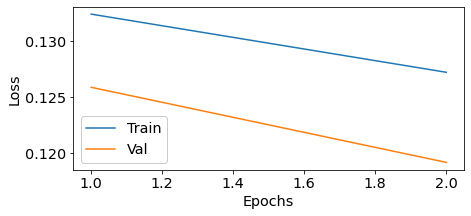

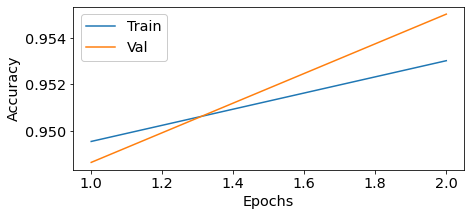

In [8]:
# for plotting of model fit convergence
if 1:
    print(history.history)

    import matplotlib.pyplot as plt

    # could make some plots of the metrics/convergance - f1 would be a better plotting score but just go with accuracy since it's easier
    fig, ax = plt.subplots(figsize=(7,3))

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(loss)+1)

    ax.plot(epochs, loss, label='Train')
    ax.plot(epochs, val_loss, label='Val')

    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    ax.legend();

    plt.savefig("SavedPlots/CNN/CNN_Convergence_Loss.png", bbox_inches='tight')


    fig, ax = plt.subplots(figsize=(7,3))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    ax.plot(epochs, acc, label='Train')
    ax.plot(epochs, val_acc, label='Val')

    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    ax.legend();

    plt.savefig("SavedPlots/CNN/CNN_Convergence_Accuracy.png", bbox_inches='tight')

Confusion matrix:
 [[1011438   15566]
 [  43952  249270]]

P-Score: 0.941, R-Score: 0.850
Accuracy: 0.955
f1: 0.893
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97   1027004
         1.0       0.94      0.85      0.89    293222

    accuracy                           0.95   1320226
   macro avg       0.95      0.92      0.93   1320226
weighted avg       0.95      0.95      0.95   1320226



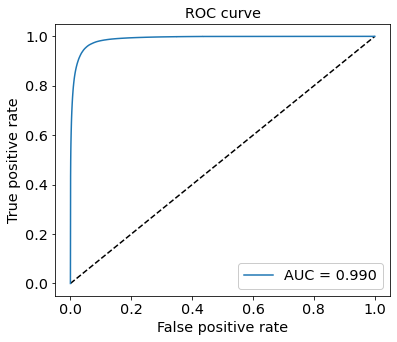

In [9]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

f1_score = peu.printClassificationMetrics(yTest, yTest_pred_prob)
auc_score = peu.makeROCPlot(yTest, yTest_pred_prob, "Test Data", 2000, "", False)

In [10]:
# check loaded model was consistent with loaded training data
if loadModel:
    if (round(f1_score, 3) != float(savedModelName.split("/")[-1].split("_")[3])) or (round(auc_score, 3) != float(savedModelName.split("/")[-1].split("_")[5][:5])):
        raise Exception("Loaded model does not align with loaded training data.")
        
# save model if desired
if saveModel:
    print('Saving model.')
    model.save(data_model_base_path + 'CNN_Model_F1_%.3f_AUC_%.3f.h5' % (f1_score, auc_score))

Saving model.




Predicting for image: /content/drive/MyDrive/MangroveClassification/Images/Florida_1_2000.tif

Image 2000 NDVI band:
Saving image:  SavedPlots/CNN/Florida_1/NDVI_Florida_1_2000.png


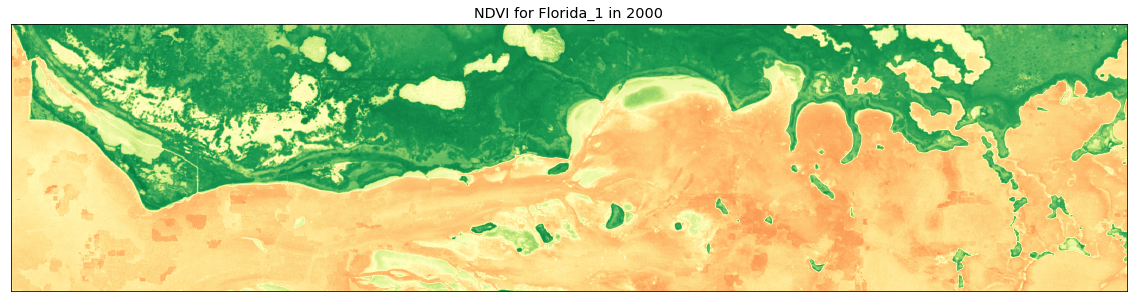


Label mangroves from 2000 data:
Saving image:  SavedPlots/CNN/Florida_1/LabeledMangroves_Florida_1_2000.png


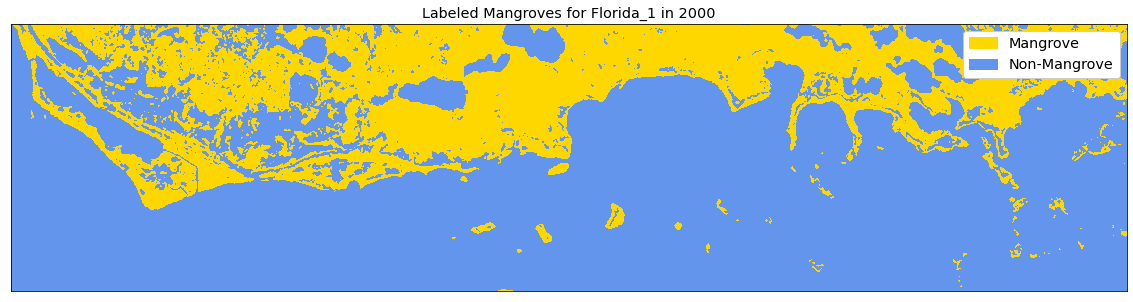


Predicted mangroves:
Saving image:  SavedPlots/CNN/Florida_1/PredictedMangroves_Florida_1_2000.png


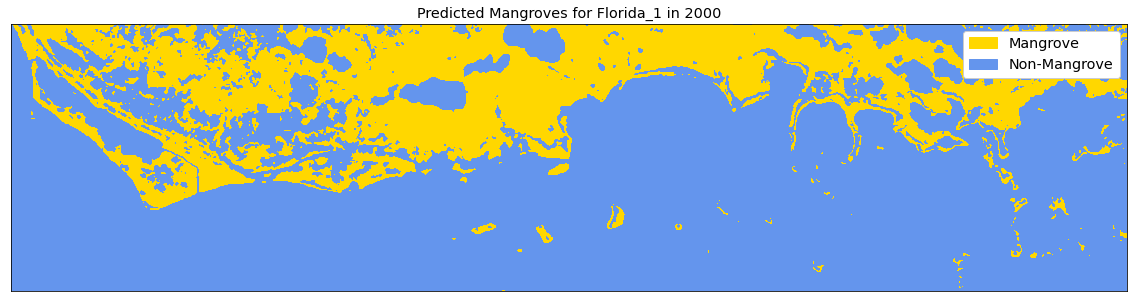


Difference between predicted and labeled mangroves from the year 2000:
Saving image:  SavedPlots/CNN/Florida_1/PvA_Florida_1_2000.png


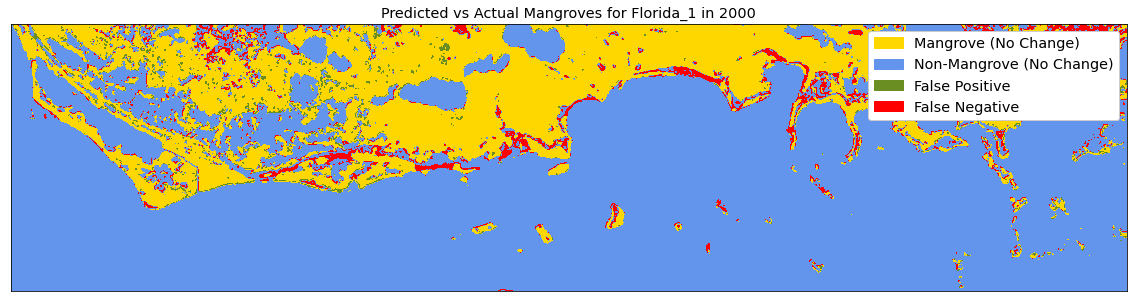

Confusion matrix:
 [[568266  11620]
 [ 32846 212743]]

P-Score: 0.948, R-Score: 0.866
Accuracy: 0.946
f1: 0.905
              precision    recall  f1-score   support

           0       0.95      0.98      0.96    579886
           1       0.95      0.87      0.91    245589

    accuracy                           0.95    825475
   macro avg       0.95      0.92      0.93    825475
weighted avg       0.95      0.95      0.95    825475

Saving image:  SavedPlots/CNN/Florida_1/ROC_Florida_1_2000.png


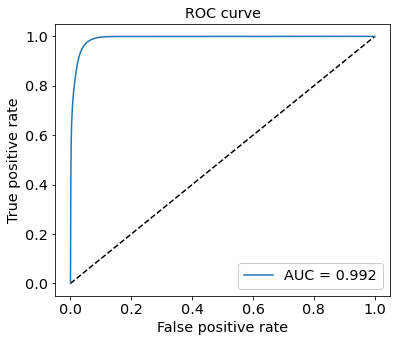

In [12]:
# apply model to new images

# test images 
diu.predictOnImageCNN(model, image_base_path + "Florida_1_2000.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_4_2000.tif", kSize)

# # # train images
# diu.predictOnImageCNN(model, image_base_path + "Florida_3_2000.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_5_2000.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_6_2000.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_7_2000.tif", kSize)

# # # future images
# diu.predictOnImageCNN(model, image_base_path + "Florida_1_2020.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_3_2020.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_4_2020.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_5_2020.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_6_2020.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_7_2020.tif", kSize)


# diu.predictOnImageCNN(model, image_base_path + "Florida_8_2000.tif", kSize)
# diu.predictOnImageCNN(model, image_base_path + "Florida_8_2020.tif", kSize)


# diu.predictOnImageCNN(model, image_base_path + "Brazil_1_2000.tif", kSize)


In [13]:
print('not now timeout!')

not now timeout!
